# Purpose of the Code

The goal of this notebook is to perform feature selection and evaluate the performance of various machine learning models, identifying the optimal combination of features and models to improve predictive performance and reduce model complexity.

## Environment Setup

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import  KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from libemg.feature_selector import FeatureSelector

In [2]:
# Parameters
device = "myo"
date = "05_14"
subject = "01"
preferred_features = ['MAV', 'SSC', 'WL']
threshold = 0.8  # Correlation threshold
all_high_corr = []
results = []
n_folds = 5

# Paths for input and output
input_folder = f'../data/extracted_features/{device}/S{subject}_{date}/'  # Input folder with raw data

In [ ]:
suffixes = ['_biceps', '_triceps', '_forearm1', '_forearm2']

# Loading Data Files

In [3]:
csv_files = [file for file in os.listdir(input_folder) if file.endswith('.csv')]
df = pd.read_csv(os.path.join(input_folder, csv_files[0]))
df.head()

,IAV_biceps,ISD_biceps,KURT_biceps,LD_biceps,MAV_biceps,MNF_biceps,MNP_biceps,MPK_biceps,RMS_biceps,SAMPEN_biceps,...,RMS_triceps,SAMPEN_triceps,SKEW_triceps,SM_triceps,SSC_triceps,VAR_triceps,WAMP_triceps,WL_triceps,ZC_triceps,label
0,1.736563,0.008704,3.304863,1.004509,0.004511,1.335065,9.845841e-08,0.007109,0.004755,0.000118,...,0.033689,0.000118,0.488448,0.204032,67,2.765726e-04,155,0.057460,25,no weight
1,2.445613,0.015762,2.888070,1.006352,0.006352,0.902709,1.851457e-07,0.007109,0.006398,0.007901,...,0.049810,0.010545,0.417209,0.210026,75,6.686829e-05,163,0.035517,27,no weight
2,2.573876,0.017231,3.084319,1.006685,0.006685,1.055315,2.035408e-07,0.007109,0.006690,0.000118,...,0.051392,0.000118,0.253653,0.321649,83,1.559642e-05,145,0.013610,31,no weight
3,2.479283,0.015971,2.900808,1.006440,0.006440,1.098310,1.887411e-07,0.006685,0.006441,0.026430,...,0.046416,0.007497,0.377234,0.282521,84,4.147747e-06,139,0.007912,33,no weight
4,2.524974,0.016572,2.774688,1.006558,0.006558,1.054011,1.958086e-07,0.006863,0.006561,0.000201,...,0.045440,0.000201,0.341720,0.249096,73,3.795827e-07,141,0.002154,34,no weight


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9727 entries, 0 to 9726
Data columns (total 69 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IAV_biceps       9727 non-null   float64
 1   ISD_biceps       9727 non-null   float64
 2   KURT_biceps      9727 non-null   float64
 3   LD_biceps        9727 non-null   float64
 4   MAV_biceps       9727 non-null   float64
 5   MNF_biceps       9727 non-null   float64
 6   MNP_biceps       9727 non-null   float64
 7   MPK_biceps       9727 non-null   float64
 8   RMS_biceps       9727 non-null   float64
 9   SAMPEN_biceps    9727 non-null   float64
 10  SKEW_biceps      9727 non-null   float64
 11  SM_biceps        9727 non-null   float64
 12  SSC_biceps       9727 non-null   int64  
 13  VAR_biceps       9727 non-null   float64
 14  WAMP_biceps      9727 non-null   int64  
 15  WL_biceps        9727 non-null   float64
 16  ZC_biceps        9727 non-null   int64  
 17  IAV_forearm1  

In [5]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the DataFrame
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42) # Split into train (70%), validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)

Train set: (6808, 69)
Validation set: (1459, 69)
Test set: (1460, 69)


# Exploratory Data Analysis (EDA)

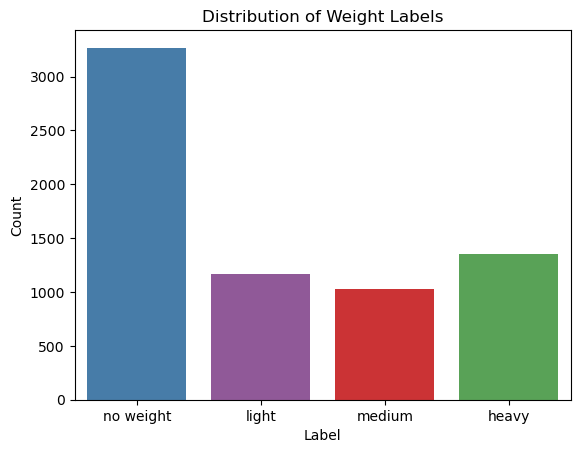

In [6]:
temp = train_df.copy()
ax = sns.countplot(data=temp, x='label', hue='label', order=['no weight', 'light', 'medium', 'heavy'], palette='Set1', legend=False)
ax.set_title('Distribution of Weight Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count') 
plt.show()

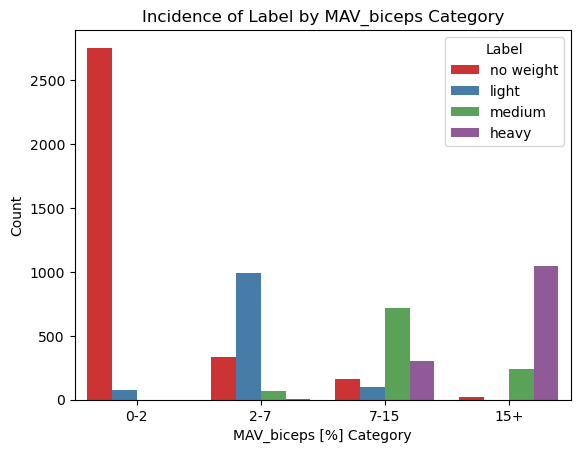

In [7]:
bins = [0, 0.02, 0.07, 0.15, np.inf]
labels = ['0-2', '2-7', '7-15', '15+']
temp['MAV_biceps_cat'] = pd.cut(temp['MAV_biceps'], bins=bins, labels=labels, right=False)

ax = sns.countplot(data=temp, x='MAV_biceps_cat', hue='label', palette='Set1', order=labels, 
                   hue_order=['no weight', 'light', 'medium', 'heavy'])
plt.legend(title='Label', loc='upper right')
plt.title('Incidence of Label by MAV_biceps Category')
plt.xlabel('MAV_biceps [%] Category')
plt.ylabel('Count')

plt.show()

# Feature Engineering

## Feature Correlation Selection

In [8]:
X = train_df.drop(columns=['label'])
y = train_df['label']

In [9]:
label_map = {'no weight': 0, 'light': 1, 'medium': 2, 'heavy': 3}
y = y.map(label_map)

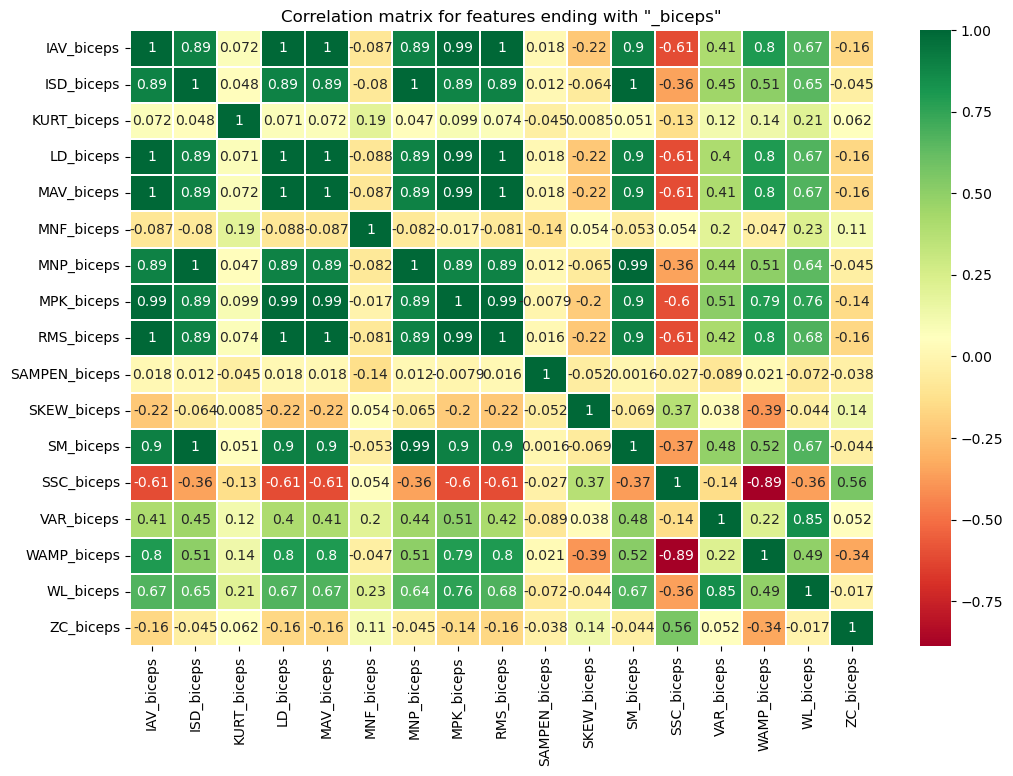

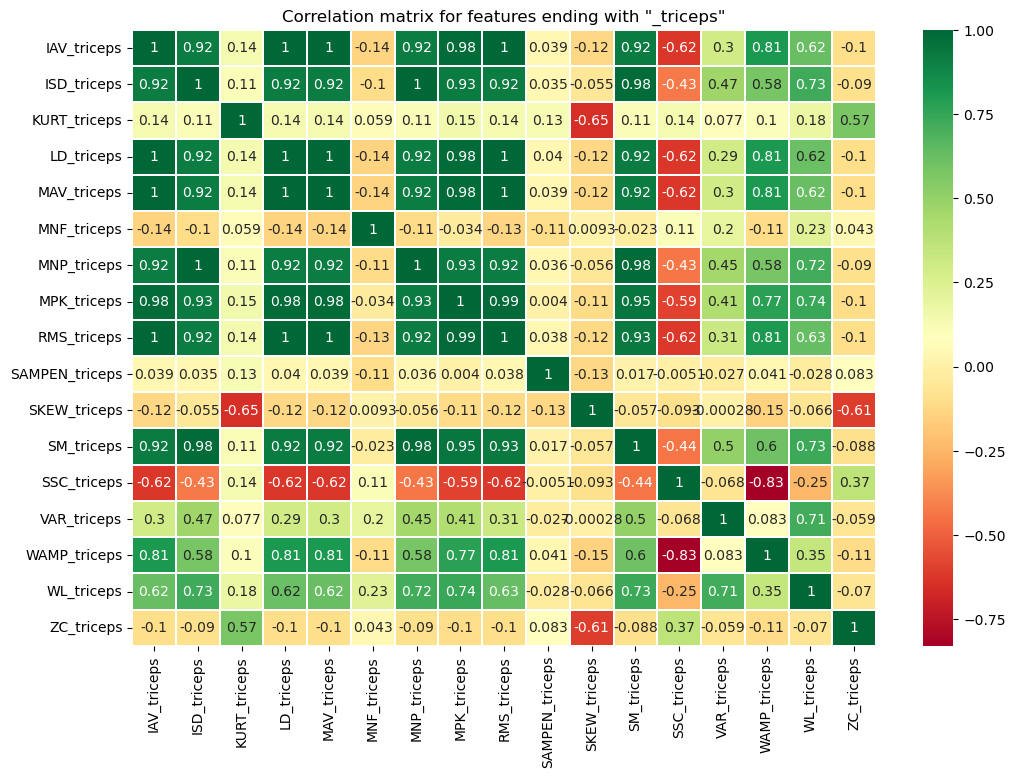

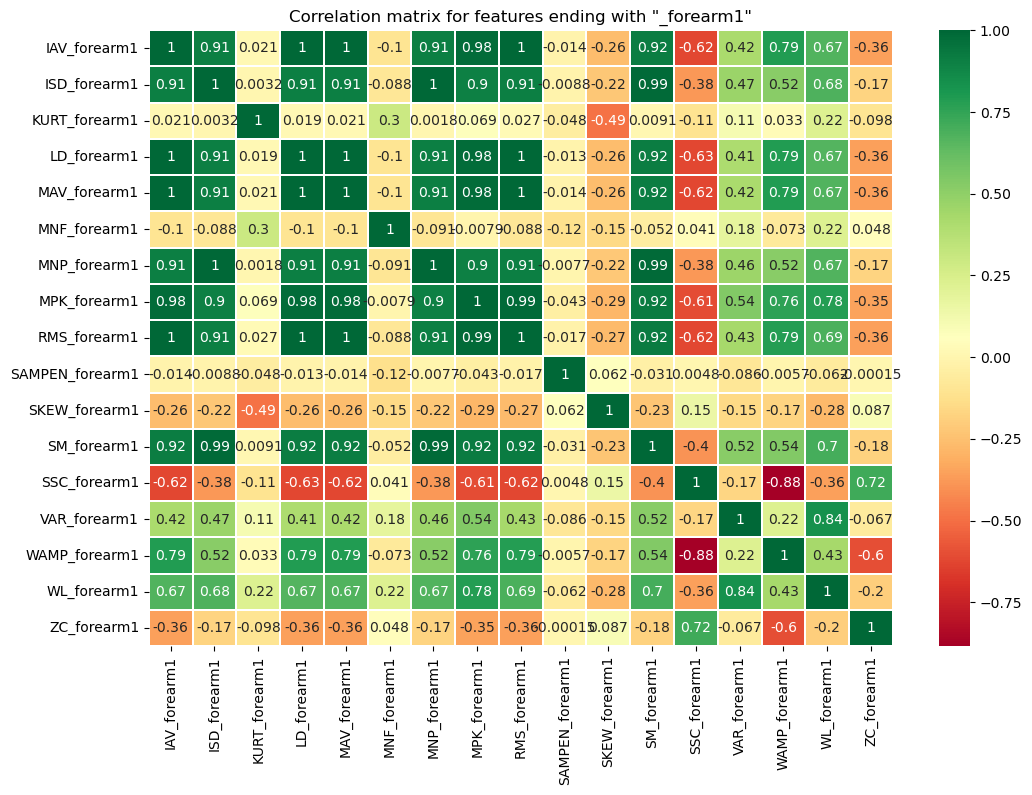

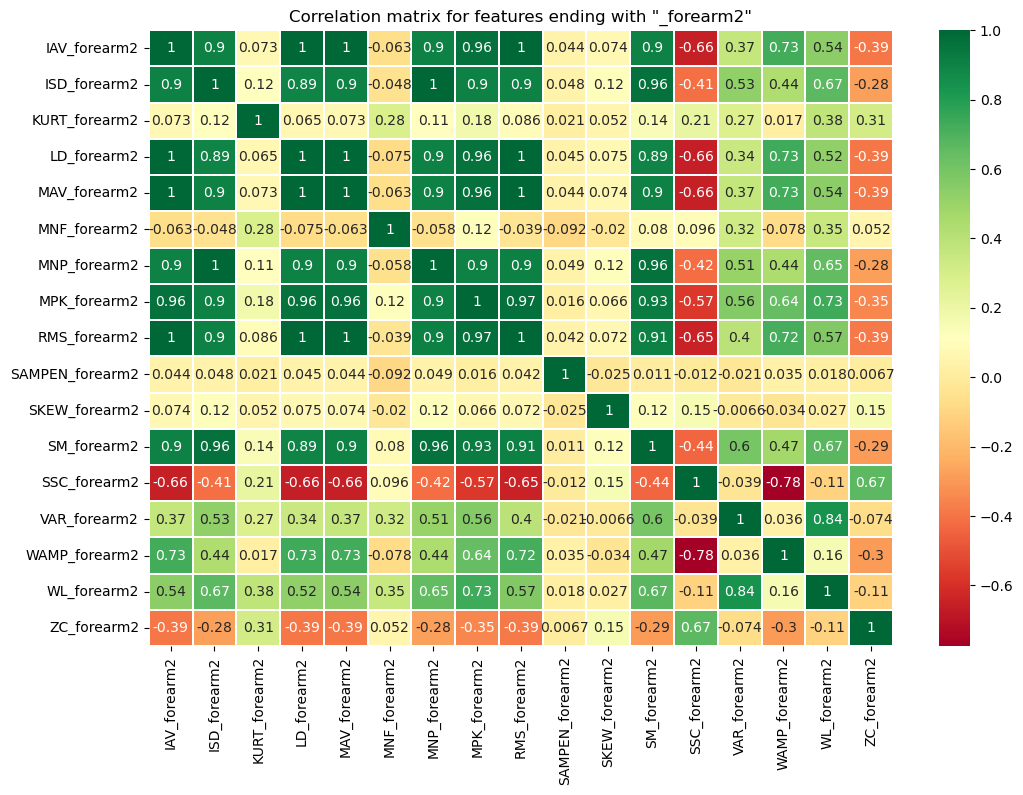

In [10]:
for suffix in suffixes:
    cols = [col for col in X.columns if col.endswith(suffix)]

    subset = X[cols]

    plt.figure(figsize=(12, 8))
    sns.heatmap(subset.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
    plt.title(f'Correlation matrix for features ending with "{suffix}"')
    plt.show()

In [11]:
# Loop through each muscle group or signal subset
for suffix in suffixes:
    # Find all columns in this group
    cols = [col for col in X.columns if col.endswith(suffix)]
    subset = X[cols]

    # Compute correlation matrix (absolute values)
    corr_matrix = subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Determine the full list of preferred features to keep for this group
    features_to_keep = [f + suffix for f in preferred_features if f + suffix in subset.columns]

    # Initialize a set to collect features to drop
    features_to_drop = set()

    # For each feature to keep, drop all other features that are highly correlated with it
    for keep_feat in features_to_keep:
        if keep_feat in upper.columns:
            # Find features with correlation > threshold and not in the keep list
            correlated = [
                col for col in upper.columns 
                if col != keep_feat and corr_matrix.loc[keep_feat, col] > threshold and col not in features_to_keep
            ]
            features_to_drop.update(correlated)

    # Drop features from main DataFrame
    X = X.drop(columns=list(features_to_drop))

# Final correlation check to print remaining correlations > 0.8
print("Remaining highly correlated features (>0.8) after filtering with MAV, SSC, WL:")

for suffix in suffixes:
    cols = [col for col in X.columns if col.endswith(suffix)]
    subset = X[cols]
    
    corr_matrix = subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr = [
        (suffix, col, row, corr_matrix.loc[row, col]) 
        for col in upper.columns 
        for row in upper.index 
        if upper.loc[row, col] > threshold
    ]
    
    all_high_corr.extend(high_corr)

if not all_high_corr:
    print("No high correlations found in any subset.")
else:
    for suffix in suffixes:
        suffix_corrs = [item for item in all_high_corr if item[0] == suffix]
        if suffix_corrs:
            print(f'\nSubset "{suffix}":')
            for _, feat1, feat2, corr_val in suffix_corrs:
                print(f'  {feat1} and {feat2} are correlated with {corr_val:.2f}')

Remaining highly correlated features (>0.8) after filtering with MAV, SSC, WL:
No high correlations found in any subset.


In [12]:
print(f"\nTotal remaining features: {len(X.columns)}")


Total remaining features: 34


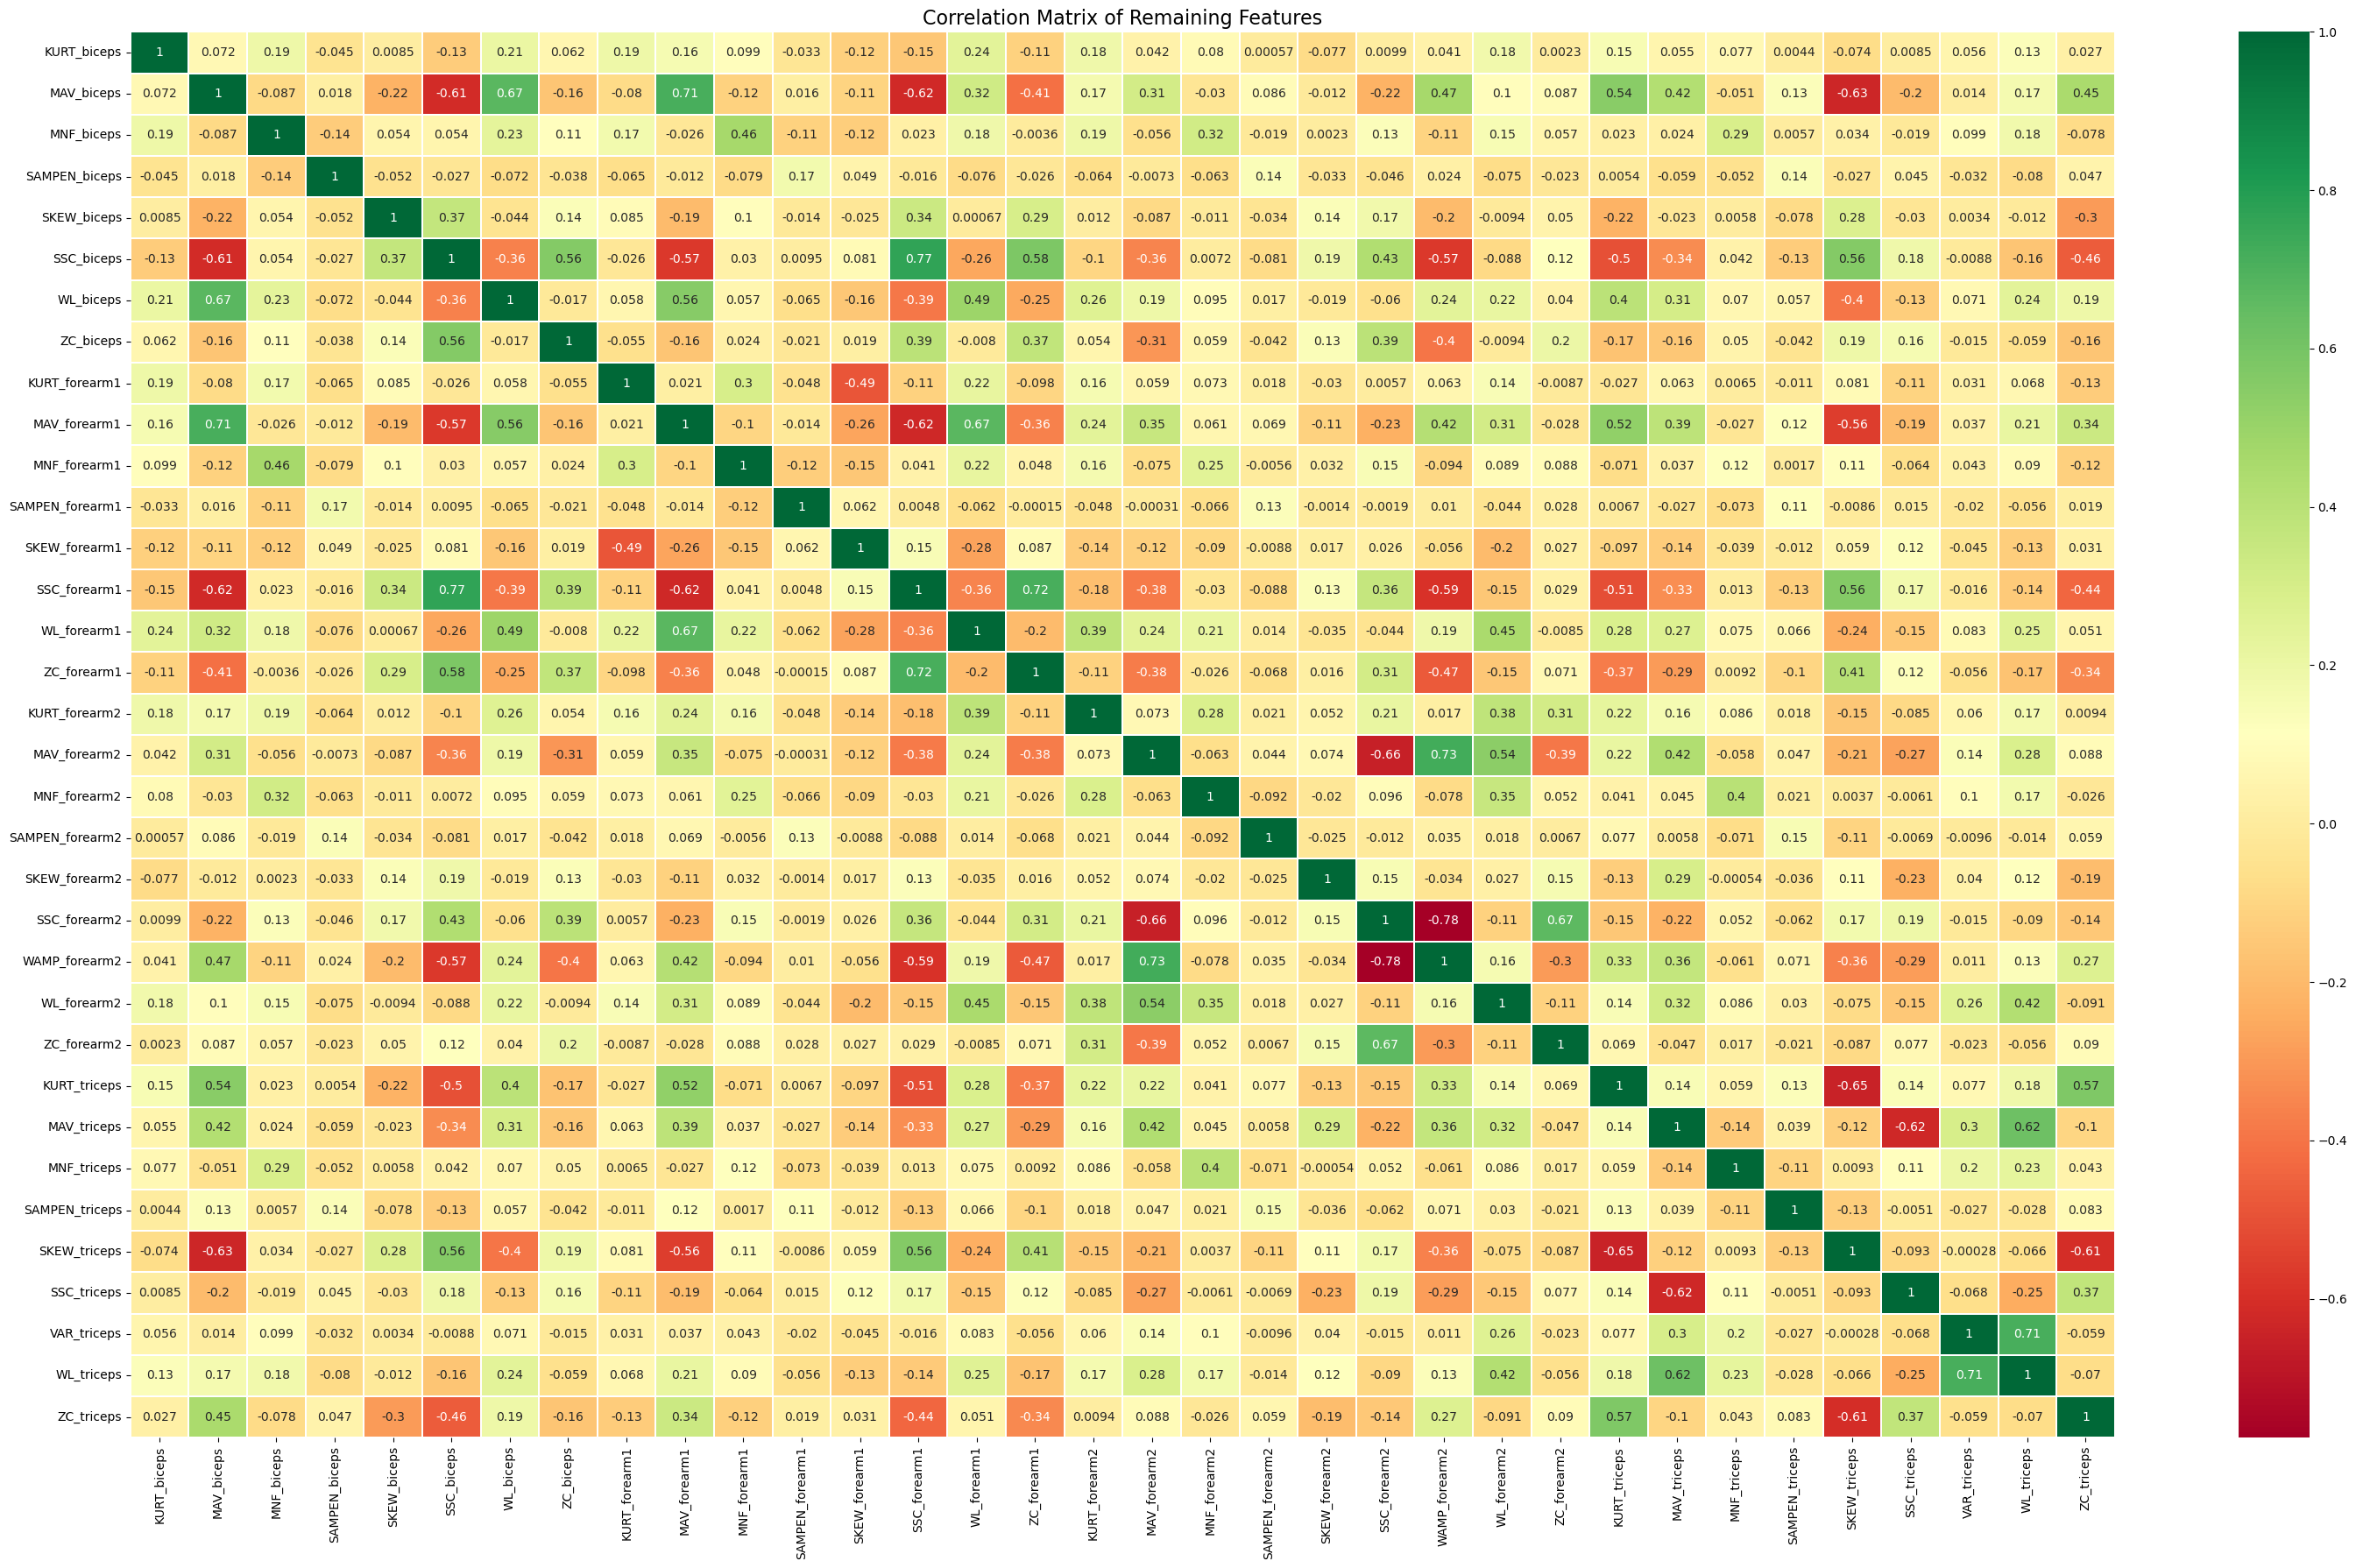

In [13]:
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', linewidths=0.3)

plt.title('Correlation Matrix of Remaining Features', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Wrapping Selection (based on accuracy)

In [14]:
metric = "accuracy"
# Initialize the feature selector
n_samples = len(X)
fold_labels = np.arange(n_samples) % n_folds

np.random.seed(42) 
np.random.shuffle(fold_labels)

fold_labels = pd.Series(fold_labels)

crossvalidation_var = {
    "var": fold_labels,
    "crossval_amount": n_folds
}
data_dict = {col: X[[col]].values for col in X.columns}

In [15]:
fs = FeatureSelector()
# Run feature selection
accuracy_results, accuracy_fs = fs.run_selection(data_dict, metric, y, crossvalidation_var)

# Print selected features
print("Features listed based on classification accuracy:")
print(accuracy_fs)

Features listed based on classification accuracy:
['MAV_biceps', 'SSC_biceps', 'MAV_forearm1', 'MAV_triceps', 'ZC_forearm2', 'SSC_forearm1', 'SKEW_biceps', 'MNF_forearm1', 'SKEW_triceps', 'KURT_forearm1', 'ZC_triceps', 'KURT_triceps', 'VAR_triceps', 'KURT_forearm2', 'WL_forearm2', 'ZC_forearm1', 'ZC_biceps', 'MAV_forearm2', 'SAMPEN_forearm2', 'WAMP_forearm2', 'SSC_forearm2', 'SKEW_forearm2', 'MNF_triceps', 'MNF_biceps', 'MNF_forearm2', 'SAMPEN_biceps', 'SAMPEN_forearm1', 'SAMPEN_triceps', 'WL_forearm1', 'SSC_triceps', 'WL_triceps', 'WL_biceps', 'KURT_biceps', 'SKEW_forearm1']


In [16]:
from sklearn.ensemble import RandomForestClassifier
for k in range(4, 35, 2): 
    features_k = accuracy_fs[:k]
    X_k = X[features_k]

    scores = cross_val_score(RandomForestClassifier(), X_k, y, cv=10)
    results.append((k, scores.mean()))

for k, acc in results:
    print(f"{k} features: Accuracy = {acc:.3f}") 

4 features: Accuracy = 0.904
6 features: Accuracy = 0.916
8 features: Accuracy = 0.920
10 features: Accuracy = 0.926
12 features: Accuracy = 0.927
14 features: Accuracy = 0.923
16 features: Accuracy = 0.925
18 features: Accuracy = 0.929
20 features: Accuracy = 0.930
22 features: Accuracy = 0.931
24 features: Accuracy = 0.932
26 features: Accuracy = 0.932
28 features: Accuracy = 0.931
30 features: Accuracy = 0.934
32 features: Accuracy = 0.931
34 features: Accuracy = 0.932


# Model Training

In [17]:
X = X[accuracy_fs[:26]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)  # per cross_val_score e cross_val_predict

--------GaussianNB Naive Bayes -------
The accuracy Gaussian Naive Bayes Classifier is 83.36
The cross validated score for Gaussian Naive Bayes classifier is: 82.95


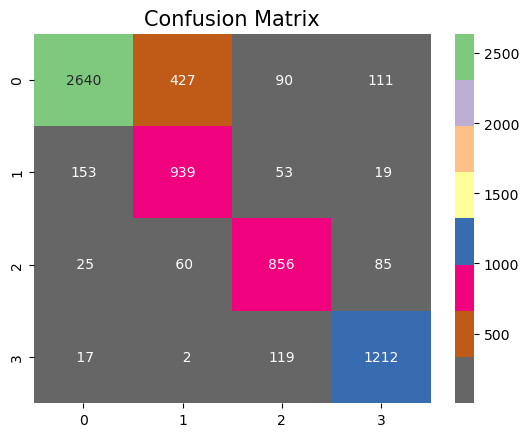

In [19]:
#################################### Naive Bayes ########################
from sklearn.naive_bayes import GaussianNB
model= GaussianNB()
model.fit(X_train,y_train)
prediction_gnb=model.predict(X_test)

print('--------GaussianNB Naive Bayes -------')
print('The accuracy Gaussian Naive Bayes Classifier is',round(accuracy_score(prediction_gnb,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True,random_state=42) # split the data into 10 equal parts

result_gnb=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Gaussian Naive Bayes classifier is:',round(result_gnb.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------SVM -------
The accuracy SVM is 91.73
The cross validated score for SVM is: 92.1


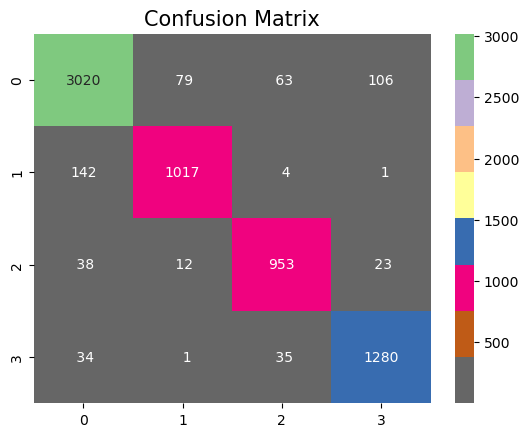

In [20]:
#################################### SVM ########################
from sklearn.svm import SVC, LinearSVC
model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)

print('--------SVM -------')
print('The accuracy SVM is',round(accuracy_score(prediction_svm,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True,random_state=42) # split the data into 10 equal parts

result_svm=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for SVM is:',round(result_svm.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

C:\Users\nicol\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nicol\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nicol\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nicol\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nicol\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

--------KNN -------
The accuracy KNN Classifier is 91.34
The cross validated score for KNN classifier is: 90.75


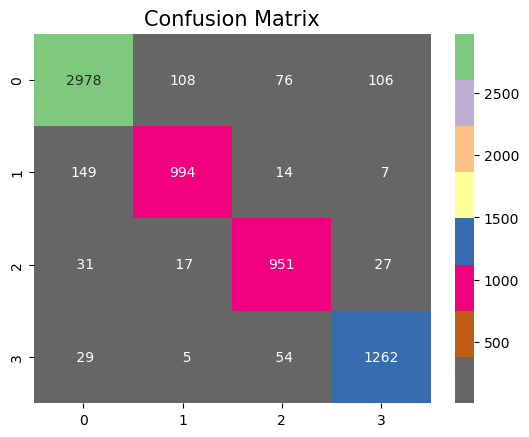

In [21]:
#################################### KNN ########################
from sklearn.neighbors import KNeighborsClassifier
model =  KNeighborsClassifier()
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)

print('--------KNN -------')
print('The accuracy KNN Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) 

result_knn=cross_val_score(model,X,y,cv=kfold,scoring='accuracy')

print('The cross validated score for KNN classifier is:',round(result_knn.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------Logistic Regression -------
The accuracy Logistic Regression is 89.67
The cross validated score for Logistic Regression is: 89.64


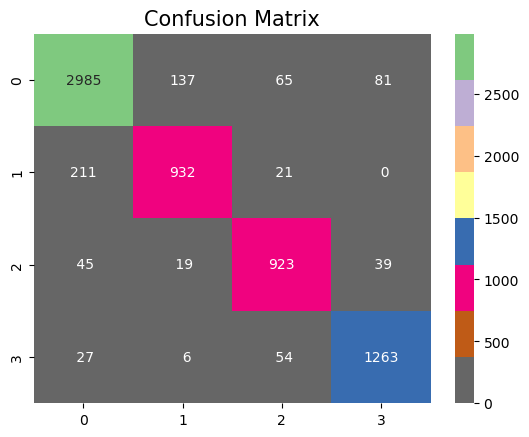

In [22]:
#################################### Logistic Regression ########################
from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(max_iter=1000)

model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)

print('--------Logistic Regression -------')
print('The accuracy Logistic Regression is',round(accuracy_score(prediction_lr,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_lr=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Logistic Regression is:',round(result_lr.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------Random Forest Classifier -------
The accuracy Random Forest Classifier  is 93.44
The cross validated score for Random Forest Classifier is: 93.07


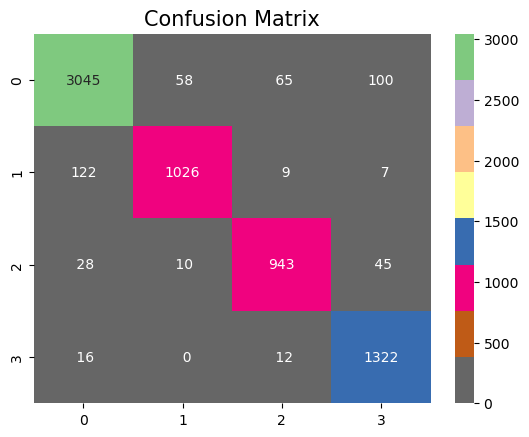

In [23]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=800,
                             min_samples_split=12,
                             max_features='sqrt',oob_score=True,
                             random_state=1,n_jobs=-1)

model.fit(X_train,y_train)
prediction_rf=model.predict(X_test)

print('--------Random Forest Classifier -------')
print('The accuracy Random Forest Classifier  is',round(accuracy_score(prediction_rf,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_rf=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Random Forest Classifier is:',round(result_rf.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

-------- Gradient Boost -------
The accuracy Gradient Boost Classifier is 93.49
The cross validated score for Gradient Boost classifier is: 92.64


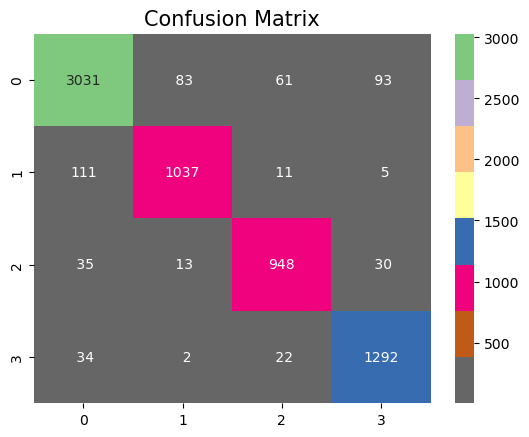

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()

model.fit(X_train,y_train)
prediction_gb=model.predict(X_test)

print('-------- Gradient Boost -------')
print('The accuracy Gradient Boost Classifier is',round(accuracy_score(prediction_gb,y_test)*100,2))

kfold = KFold(n_splits=8, shuffle=True,random_state=42) # split the data into 10 equal parts

result_gb=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Gradient Boost classifier is:',round(result_gb.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------ADA Boost -------
The accuracy ADA Boost Classifier is 60.89
The cross validated score for ADA Boost classifier is: 72.15


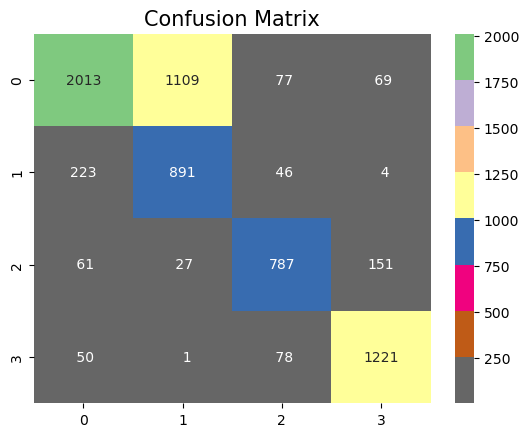

In [25]:
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier(algorithm='SAMME')

model.fit(X_train,y_train)
prediction_ada=model.predict(X_test)

print('--------ADA Boost -------')
print('The accuracy ADA Boost Classifier is',round(accuracy_score(prediction_ada,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_ada=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for ADA Boost classifier is:',round(result_ada.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

In [26]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Boosting'],
    'Score': [result_svm.mean(), result_knn.mean(), result_lr.mean(), 
              result_rf.mean(), result_gnb.mean(), result_ada.mean(), 
              result_gb.mean()]})
models.sort_values(by='Score',ascending=False)

,Model,Score
3,Random Forest,0.930672
6,Gradient Boosting,0.926414
0,Support Vector Machines,0.920978
1,KNN,0.907462
2,Logistic Regression,0.896449
4,Naive Bayes,0.829467
5,AdaBoostClassifier,0.721510
